# Introduction to qsoverlay

This notebook introduces the quantumsim_overlay (qsoverlay) package, and demonstrates how to use it on a simple Bell state preparation example.

Qsoverlay is a package to remove some of the overhead needed in parametrizing a circuit for a simulation with noise. In particular, it keeps track of the time and error parameters in a circuit, which otherwise need to be done by the user.

Qsoverlay consists of two parts - the circuit_builder, which creates quantumsim circuits, and a set of setup files which dictate how gates look in a given experimental model. 

In [1]:
import numpy as np

Before we start making a circuit, we need to define the (simulated) hardware that we will work on. The hardware needs some qubits and gates (there are a few more optional pieces you can add depending on how realistic you want to get). The qubits themselves need labels, and the rest of the defining is done using a setup file, which is specific to whatever physical implementation you want to simulate. 

We're going to simulate our experiment on models of the transmon qubits in DiCarloLab, so we use DiCarlo_setup. This has a quick_setup function that should be sufficient for any simulation where we want symmetric qubits.

In [2]:
from qsoverlay import DiCarlo_setup
qubit_list = ['swap','cp']
setup = DiCarlo_setup.quick_setup(qubit_list)

The setup here contains a few things. Importantly for us right now it contains a dictionary of allowed gates with some parameters (e.g. the length of the gate), and for each of the qubits that we've specified, a dictionary of qubit parameters - things such as T1, T2, etc.

In [5]:
print(setup.qubit_dic.keys())

# Note that some gates can have multiple handles - RotateX and RX
# have the exact same function here.
print(setup.gate_dic.keys())

dict_keys(['swap', 'cp'])
dict_keys(['CZ', 'C-Phase', 'CPhase', 'RotateX', 'RX', 'Rx', 'RotateY', 'RY', 'Ry', 'RotateZ', 'RZ', 'Rz', 'RotateXY', 'RXY', 'Rxy', 'RotateEuler', 'Measure', 'ISwap', 'ISwapRotation', 'prepz', 'PrepGate', 'ResetGate', 'Reset', 'Had', 'H', 'CNOT', 'CRX', 'X', 'Y', 'Z'])


Circuits are made through a builder, which takes care of everything except for defining the gates.

In [7]:
from qsoverlay.circuit_builder import Builder

# Make the builder with the chosen setup.
b = Builder(setup)

# Create the circuit
b.add_gate('RotateY',['swap'],angle=np.pi/2)
b.add_gate('RotateY',['cp'],angle=np.pi/2)
b.add_gate('CZ',['cp','swap'])
b.add_gate('RotateY',['cp'],angle=-np.pi/2)

# Get the quantumsim circuit after waiting gates are added.
b.finalize()
bell_circuit = b.circuit

The circuit is now a regular quantumsim circuit which can be plotted

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9c5565bbe0>)

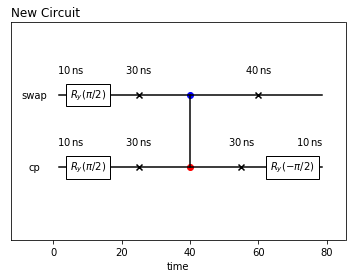

In [8]:
%matplotlib inline
bell_circuit.plot()

And applied to a SDM

In [9]:
from quantumsim.sparsedm import SparseDM
bell_state = SparseDM(bell_circuit.get_qubit_names())
bell_circuit.apply_to(bell_state)

In [10]:
bell_state.peak_multiple_measurements(['cp','swap'])

[({'cp': 0, 'swap': 0}, 0.4997517951504599),
 ({'cp': 1, 'swap': 0}, 0.001413511463122148),
 ({'cp': 0, 'swap': 1}, 0.0011109352511990194),
 ({'cp': 1, 'swap': 1}, 0.4977237581352225)]

And the full density matrix can be obtained

In [11]:
bell_state.full_dm.to_array().round(3)

array([[ 0.5  +0.j, -0.001+0.j,  0.   +0.j, -0.497+0.j],
       [-0.001+0.j,  0.001+0.j, -0.   +0.j,  0.   +0.j],
       [ 0.   +0.j, -0.   +0.j,  0.001+0.j, -0.   +0.j],
       [-0.497+0.j,  0.   +0.j, -0.   +0.j,  0.498+0.j]])

In addition to the above, there is one nice addition to qsoverlay: the ability to save and reload circuits with minimal overhead. The representation of our previous circuit can be found in the 'circuit_list' of our builder

In [12]:
circuit_list = b.circuit_list
print(circuit_list)

[('RotateY', 'swap', 1.5707963267948966), ('RotateY', 'cp', 1.5707963267948966), ('CZ', 'cp', 'swap'), ('RotateY', 'cp', -1.5707963267948966)]


This can be immediately re-inserted into a new builder. Here, we're going to do this with the noise flag off, meaning that our qubits are treated as perfect

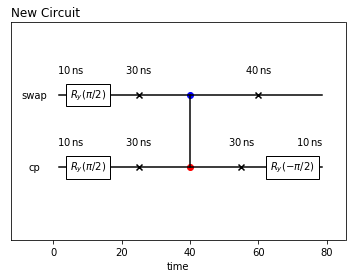

In [15]:
setup = DiCarlo_setup.quick_setup(qubit_list)
b2 = Builder(setup)

# Replacing the entire input for the circuit
b2.add_circuit_list(circuit_list)

# Get circuit and apply to state
b2.finalize()
new_bell_circuit = b2.circuit
new_bell_circuit.plot()
new_bell_state = SparseDM(new_bell_circuit.get_qubit_names())
new_bell_circuit.apply_to(new_bell_state)

To check that these are the same, compare the density matrices from the two

In [16]:
print(np.linalg.norm(new_bell_state.full_dm.to_array()-bell_state.full_dm.to_array()))

0.0


We can also recreate the same circuit with different parameters. Let's try a new simulation with qubits that have a T1 and T2 of 1us instead of 30us (the standard), and compare this to a perfect circuit (to see the bell state fidelity)

In [18]:
# T1 is changed from the default in the setup; all times are given in nanoseconds
setup_perfect = DiCarlo_setup.quick_setup(qubit_list, noise_flag=False)
setup_noisy = DiCarlo_setup.quick_setup(qubit_list, t1=1000, t2=1000)

b_perfect = Builder(setup_perfect)
b_noisy = Builder(setup_noisy)

# Replacing the entire input for the circuit
b_perfect.add_circuit_list(circuit_list)
b_noisy.add_circuit_list(circuit_list)

# Get circuit and apply to state
b_perfect.finalize()
b_noisy.finalize()
worse_bell_circuit = b_noisy.circuit
worse_bell_state = SparseDM(worse_bell_circuit.get_qubit_names())
worse_bell_circuit.apply_to(worse_bell_state)
perfect_bell_circuit = b_perfect.circuit
perfect_bell_state = SparseDM(perfect_bell_circuit.get_qubit_names())
perfect_bell_circuit.apply_to(perfect_bell_state)

In [19]:
#fidelity hack taken from the quantumsim tutorial
import quantumsim
if quantumsim.sparsedm.using_gpu == False:
    print("Bell state fidelity: ", np.dot(worse_bell_state.full_dm.dm.ravel(), perfect_bell_state.full_dm.dm.ravel()))

Bell state fidelity:  0.914780943816387
